# Introduction
This notebook cleans tweets and then **trains successive sequential neural networks in order to generate labels on the remaining ~8,000 data points.** The first NN is trained (and validated) on a split of the 2,014 tweets I manually labeled in the notebook `data_labeling.ipynb`. This NN then predicts labels on another batch of tweets, and the process is repeated until all tweets have been labeled.

# Libraries

In [1]:
import pandas as pd
pd.set_option("max_columns", None)
pd.set_option('display.max_colwidth', -1)

import json

import numpy as np
np.random.seed(0)

import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.optimizers import RMSprop, Adam

from sklearn.model_selection import train_test_split

import re

import string

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Visualization Helper Function

This function is used to help visualize model performance, and will be called after each model's fitting.

In [2]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

# Import Data And Labels

Here I'm just building the DF from saved Twitter data and adding the labels from `data_labeling.ipynb`.

In [3]:
tweet_list = []
for i in range(102):
    with open(f'data_no_RT/data_{i}.txt') as f:
        temp_f = json.load(f)
    for x in range(len(temp_f['statuses'])):
        tweet_list.append(temp_f['statuses'][x]['full_text'])

In [4]:
df = pd.DataFrame(tweet_list)
df.rename(columns = {0:'tweet'}, inplace=True)
df['sentiment'] = 'unlabeled'

In [5]:
with open('labels/labels.txt') as f:
    sentiment_list = json.load(f)
df['sentiment'] = sentiment_list
df['sentiment'].value_counts()

unlabeled    8147
2            992 
3            554 
1            468 
             3   
Name: sentiment, dtype: int64

In [6]:
df = df[df['sentiment'] != ""]

In [7]:
df.head(15)

,tweet,sentiment
0,@chrisfit229 I just meant the amazon link friend. 😭😭😭 TY!,unlabeled
1,"If you don’t like horror movies, which I don’t, October is a shit month for new release movies, on sky, Netflix and Amazon,",unlabeled
2,Doing this webcomic/art thing again. I've been practicing a lot. Maybe a few pairs of giant breasts and some #deltporn can help drown out the negativity on the Internet.\n#artwip #comics #drawing #busty #waifu #amazon #snusnu https://t.co/sBle5g5TNe,3
3,"@Poetryman551 A late-night phone call, a missing kid, a murdered family, and no one is talking. A promise made and kept though it might mean a 15 yr old's death. #blackrosewriting @brwpublisher #thriller #crime KDP Select at Amazon at https://t.co/CmuXmKEppI\nprint at https://t.co/JtshcAQvAy",1
4,Do YOU have all these stand alone stories? #LunaLakeCabins by our @Annie_Acorn Start with Luna Lake Cabins-The First Year https://t.co/C1QYZixP1d #AppleBooks #Kobo #Nook #Walmart #Romance #BestRead #Bookplugs #SNRTG #BYNR #authorRT https://t.co/dXpsmKX8N9,unlabeled
5,@GBR2909 @AmazonUK You're not riding this by yourself. It gets worse every day. Guess what? Amazon doesn't give a damn!,unlabeled
6,@femmina i would mix her medicine with this stuff and it helped. the smell is so strong it's hard to notice there's anything else mixed in. https://t.co/udsxxO5Zqy,3
7,Best belive imma take advantage of my amazon prime account,3
8,"“I get more business from sitting on this barstool than advertising in any publication, including Tobin’s Spirit Guide.” https://t.co/tUe6D2j7sJ #amwriting #booknerd",unlabeled
9,Well check this out. Gluttony is already available for purchase. If you’re looking for the story of a demanding boss who suddenly discovers how desperately she really needs the taste of her assistant’s cream... today is your lucky day. \n\nhttps://t.co/nQSJK5oHC5 https://t.co/H0dPuwLHUm,2


# Stemming And Data Preparation

## `stem_clean()` Function

**Stemming is being used to reduce the complexity and size of the total vocabulary in this dataset.** Since Twitter users can input whatever they want as a word, there's quite a variety. Stemming these words (while not always change-producing) will help to cut down this massive number of unique character strings. The following function does just that, as well as some other **basic cleaning and tokenization.**

In [8]:
ps = PorterStemmer() 

In [9]:
def stem_clean(text):
    '''
    Takes in a piece of text and cleans and stems it. Removes all punctuation,
    URL's, usernames, and hashtags. Sets everything to lowercase, tokenizes,
    removes stopwords, stems and returns it as a list of tokens.
    ---
    text
        String input to be cleaned.
    '''
    stop_words = stopwords.words("english")
    
    text = re.sub('@\S+', '', text)
    text = re.sub('http\S+', '', text)
    text = re.sub('#\S+', '', text)
    for i in string.punctuation:
        text = text.replace(i, '').lower()
    
    tokens = nltk.word_tokenize(text)
    new_tokens = []
    for token in tokens:
        if token.lower() not in stop_words:
            new_tokens.append(ps.stem(token))
            
    return new_tokens

In [10]:
df_stem = df.copy()

In [11]:
df_stem.tweet = df_stem.tweet.map(stem_clean)

In [12]:
df_stem.head()

,tweet,sentiment
0,"[meant, amazon, link, friend, 😭😭😭, ty]",unlabeled
1,"[’, like, horror, movi, ’, octob, shit, month, new, releas, movi, sky, netflix, amazon]",unlabeled
2,"[webcomicart, thing, ive, practic, lot, mayb, pair, giant, breast, help, drown, neg, internet]",3
3,"[latenight, phone, call, miss, kid, murder, famili, one, talk, promis, made, kept, though, might, mean, 15, yr, old, death, kdp, select, amazon, print]",1
4,"[stand, alon, stori, start, luna, lake, cabinsth, first, year]",unlabeled


As we can see, the tweets from above have been made shorter and much less difficult to read. They also contain truncated words such as `'movi'` and `'stori'`.

## Prepping Stemmed DataFrame For Modeling

Below, another function `data_to_sequences` will be defined that **prepares the lists of tokenized strings above for neural network modeling.** We must get the strings in a more computer-friendly form, and in our case, that is by turning them into **padded arrays** where each numerical value in the array represents a unique word within the `total_vocabulary`.

First we need to instantiate a `Tokenizer` based on the `total_vocab` of our dataset:

In [13]:
total_vocab_stem = set(word for text in df_stem['tweet'] for word in text)
len(total_vocab_stem)

16212

In [14]:
tokenizer = text.Tokenizer(num_words = len(total_vocab_stem))
tokenizer.fit_on_texts(list(df_stem['tweet']))

We then should also find out what the longest tweet in our dataset is. No need to pad the sequences any longer than this:

In [15]:
length_list = []
for i in range(len(df_stem)):
    length_list.append(len(df_stem.iloc[i]['tweet']))
max(length_list)

45

Then we can define a function that calls that `Tokenizer` on a batch of tweets:

In [16]:
def data_to_sequences(df):
    '''
    Takes in a Pandas DataFrame and returns a list of padded tokenized arrays.
    ---
    df
        Pandas DataFrame. Must have ['tweet'] as a column.
    '''
    list_tokenized_tweets = tokenizer.texts_to_sequences(df['tweet'])
    return sequence.pad_sequences(list_tokenized_tweets, maxlen = 45)

And then we can use it on our dataset and pass it along to our model, after first selecting out only the labeled tweets to fit on:

In [17]:
df_label_stem = df_stem[df_stem['sentiment'] != 'unlabeled']
len(df_label_stem)

2014

In [18]:
X = data_to_sequences(df_label_stem)
y = pd.get_dummies(df_label_stem['sentiment']).values

X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(X, y, test_size = 0.2, random_state=0)

Here's an example of what the data will look like as it's fed into the neural network:

In [19]:
X_train_stem[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0, 3686, 4353,  970,  122, 2378, 1054, 2609,   49,
        306])

In [20]:
y_train_stem[0]

array([0, 0, 1], dtype=uint8)

# Stem Model 1 - Baseline

This model follows a pretty basic NLP setup. It takes in the word embeddings, has a layer of long-short-term memory, and then implements pooling, dropout, and regularization to avoid overfitting.

In [21]:
stem_model = Sequential()

In [22]:
embed_in = len(total_vocab_stem)
embed_out = max(length_list)
lambda_coeff = 0.1

stem_model.add(Embedding(embed_in, embed_out))
stem_model.add(LSTM(8, return_sequences=True))
stem_model.add(GlobalMaxPool1D())
stem_model.add(Dropout(0.4))
stem_model.add(Dense(25, activation='tanh', kernel_regularizer=regularizers.l2(lambda_coeff)))
stem_model.add(Dense(3, activation='softmax'))

In [23]:
stem_model.compile(loss='categorical_crossentropy',
                   optimizer='Adam',
                   metrics=['accuracy'])

In [24]:
stem_results = stem_model.fit(X_train_stem, y_train_stem, epochs=20, batch_size=30, validation_split=0.3)

Train on 1127 samples, validate on 484 samples
Epoch 1/20
1127/1127 [==============================] - 3s 2ms/step - loss: 2.2370 - acc: 0.4241 - val_loss: 2.0541 - val_acc: 0.5083
Epoch 2/20
1127/1127 [==============================] - 2s 2ms/step - loss: 1.9271 - acc: 0.4783 - val_loss: 1.7872 - val_acc: 0.5083
Epoch 3/20
1127/1127 [==============================] - 2s 2ms/step - loss: 1.6908 - acc: 0.4783 - val_loss: 1.5860 - val_acc: 0.5083
Epoch 4/20
1127/1127 [==============================] - 2s 2ms/step - loss: 1.4928 - acc: 0.4916 - val_loss: 1.4164 - val_acc: 0.5165
Epoch 5/20
1127/1127 [==============================] - 2s 2ms/step - loss: 1.2836 - acc: 0.5892 - val_loss: 1.2607 - val_acc: 0.5950
Epoch 6/20
1127/1127 [==============================] - 2s 2ms/step - loss: 1.0576 - acc: 0.6708 - val_loss: 1.1682 - val_acc: 0.5826
Epoch 7/20
1127/1127 [==============================] - 2s 2ms/step - loss: 0.8709 - acc: 0.6965 - val_loss: 1.1284 - val_acc: 0.5909
Epoch 8/20
1127

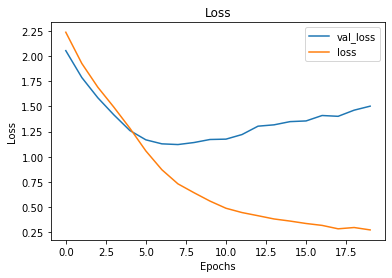

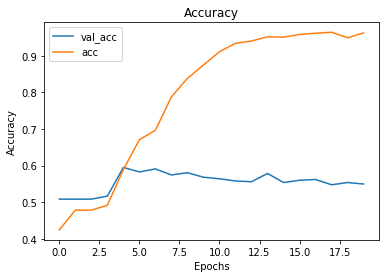

In [25]:
visualize_training_results(stem_results)

## Saving Model

In [26]:
stem_model.save('models/stem_model')

# Recursively Labeling All The Data In Batches

I'll now use this model to **automate the rest of the labeling process.** It will not be perfect, and in fact will likely have a sizable inherited error--The `val_acc` shortcomings of the first model will compound into the next and so on. Time and labor-cost restrictions have prevented me from getting more labels on this data, which would *absolutely* improve accuracy all around. There is no doubt.

The full dataset contains **10161 tweets,** 2014 of which have been manually labeled. We now need to **apply labels to these remaining 8147 tweets.** The gist of how this will be done is:
- Get 1000 unlabeled tweets from the stemmed DataFrame.
- Use most recent model to predict their labels.
- Assign predicted labels to those same 1000 tweets.
- Create a new neural network, using these 3014 labeled tweets.
- Repeat process until all tweets labeled, pulling 50% as many unlabeled tweets as there are total labeled tweets at any given iteration.

## `df_to_label` And Batches To Label

As described above, I'm now pulling out 4 batches of data to label, each larger than the last, til every unlabeled tweet is part of a batch.

In [27]:
df_to_label = df_stem[df_stem['sentiment'] == 'unlabeled']
len(df_to_label)

8147

In [28]:
batch_1 = df_to_label[:1000]
batch_2 = df_to_label[1001:2500]
batch_3 = df_to_label[2501:4750]
batch_4 = df_to_label[4751:8147]

## `label_batch()` Function

In [29]:
def label_batch(batch, model):
    '''
    Takes in a Pandas DataFrame, processes data and predicts sentiment.
    ---
    batch
        Pandas DataFrame. Must have a column ['tweet'] that is composed of
        list of strings for each row.
    model
        Trained neural network.
    '''
    sequences = data_to_sequences(batch)

    preds = model.predict(sequences)

    sent_pred = []

    for i in range(len(preds)):
        pred = list(preds[i])
        max_pred = max(pred)
        sent_pred.append(pred.index(max_pred) + 1)

    batch['sentiment'] = sent_pred

In [30]:
label_batch(batch_1, stem_model)

C:\Users\Steven\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [31]:
df_label_stem = df_label_stem.append(batch_1).reset_index()
# Accidentally had as string before, now had 6 unique sentiment values. Fixed:
df_label_stem['sentiment'] = df_label_stem['sentiment'].astype(int)

## Stem Model 2

I will not be providing explanation for each model as they are effectively the same from here on out. Just remember that now we are retraining with slightly larger data sizes each time.

In [32]:
X = data_to_sequences(df_label_stem)
y = pd.get_dummies(df_label_stem['sentiment']).values

X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(X, y, test_size = 0.2, random_state=0)

In [33]:
stem_model_2 = Sequential()

embed_in = len(total_vocab_stem)
embed_out = max(length_list)
lambda_coeff = 0.1

stem_model_2.add(Embedding(embed_in, embed_out))
stem_model_2.add(LSTM(8, return_sequences=True))
stem_model_2.add(GlobalMaxPool1D())
stem_model_2.add(Dropout(0.4))
stem_model_2.add(Dense(25, activation='tanh', kernel_regularizer=regularizers.l2(lambda_coeff)))
stem_model_2.add(Dense(3, activation='softmax'))

stem_model_2.compile(loss='categorical_crossentropy',
                   optimizer='Adam',
                   metrics=['accuracy'])

stem_results_2 = stem_model_2.fit(X_train_stem, y_train_stem, epochs=20, batch_size=30, validation_split=0.3)

Train on 1687 samples, validate on 724 samples
Epoch 1/20
1687/1687 [==============================] - 4s 2ms/step - loss: 2.0056 - acc: 0.4594 - val_loss: 1.7938 - val_acc: 0.4820
Epoch 2/20
1687/1687 [==============================] - 3s 2ms/step - loss: 1.6608 - acc: 0.4665 - val_loss: 1.5246 - val_acc: 0.4820
Epoch 3/20
1687/1687 [==============================] - 3s 2ms/step - loss: 1.4274 - acc: 0.4665 - val_loss: 1.3333 - val_acc: 0.4820
Epoch 4/20
1687/1687 [==============================] - 3s 2ms/step - loss: 1.2095 - acc: 0.5424 - val_loss: 1.1379 - val_acc: 0.5829
Epoch 5/20
1687/1687 [==============================] - 3s 2ms/step - loss: 0.9536 - acc: 0.6657 - val_loss: 1.0333 - val_acc: 0.6119
Epoch 6/20
1687/1687 [==============================] - 3s 2ms/step - loss: 0.7685 - acc: 0.7718 - val_loss: 0.9936 - val_acc: 0.6243
Epoch 7/20
1687/1687 [==============================] - 3s 2ms/step - loss: 0.6292 - acc: 0.8477 - val_loss: 0.9888 - val_acc: 0.6423
Epoch 8/20
1687

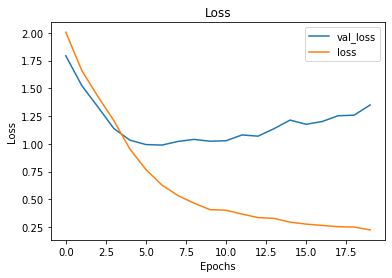

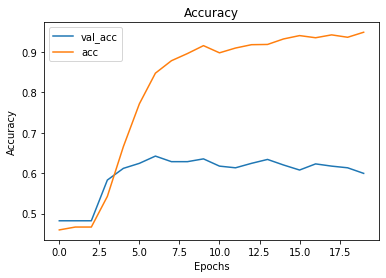

In [34]:
visualize_training_results(stem_results_2)

### Saving Model

In [35]:
stem_model_2.save('models/stem_model_2')

## Batch 2 And Stem Model 3

### Batch 2

In [36]:
label_batch(batch_2, stem_model_2)

C:\Users\Steven\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [37]:
df_label_stem = df_label_stem.append(batch_2).reset_index()

C:\Users\Steven\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


### Stem Model 3

In [38]:
X = data_to_sequences(df_label_stem)
y = pd.get_dummies(df_label_stem['sentiment']).values

X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(X, y, test_size = 0.2, random_state=0)

In [39]:
stem_model_3 = Sequential()

embed_in = len(total_vocab_stem)
embed_out = max(length_list)
lambda_coeff = 0.1

stem_model_3.add(Embedding(embed_in, embed_out))
stem_model_3.add(LSTM(8, return_sequences=True))
stem_model_3.add(GlobalMaxPool1D())
stem_model_3.add(Dropout(0.4))
stem_model_3.add(Dense(25, activation='tanh', kernel_regularizer=regularizers.l2(lambda_coeff)))
stem_model_3.add(Dense(3, activation='softmax'))

stem_model_3.compile(loss='categorical_crossentropy',
                   optimizer='Adam',
                   metrics=['accuracy'])

stem_results_3 = stem_model_3.fit(X_train_stem, y_train_stem, epochs=20, batch_size=30, validation_split=0.3)

Train on 2527 samples, validate on 1083 samples
Epoch 1/20
2527/2527 [==============================] - 6s 2ms/step - loss: 2.0502 - acc: 0.4484 - val_loss: 1.7791 - val_acc: 0.4072
Epoch 2/20
2527/2527 [==============================] - 5s 2ms/step - loss: 1.5662 - acc: 0.4523 - val_loss: 1.4123 - val_acc: 0.4072
Epoch 3/20
2527/2527 [==============================] - 5s 2ms/step - loss: 1.2365 - acc: 0.5208 - val_loss: 1.1529 - val_acc: 0.5014
Epoch 4/20
2527/2527 [==============================] - 4s 2ms/step - loss: 0.9486 - acc: 0.6209 - val_loss: 1.0115 - val_acc: 0.6020
Epoch 5/20
2527/2527 [==============================] - 4s 2ms/step - loss: 0.7366 - acc: 0.7851 - val_loss: 0.9791 - val_acc: 0.6094
Epoch 6/20
2527/2527 [==============================] - 5s 2ms/step - loss: 0.6052 - acc: 0.8243 - val_loss: 1.0049 - val_acc: 0.6168
Epoch 7/20
2527/2527 [==============================] - 5s 2ms/step - loss: 0.5086 - acc: 0.8607 - val_loss: 1.0479 - val_acc: 0.6214
Epoch 8/20
252

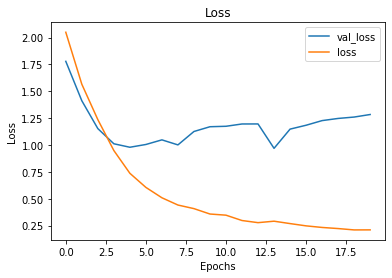

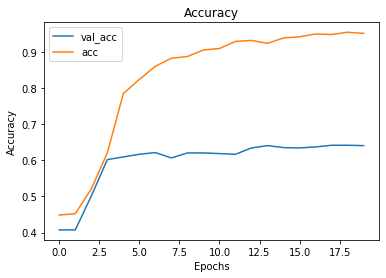

In [40]:
visualize_training_results(stem_results_3)

#### Saving Model

In [41]:
stem_model_3.save('models/stem_model_3')

## Batch 3 And Stem Model 4

### Batch 3

In [42]:
label_batch(batch_3, stem_model_3)

C:\Users\Steven\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [43]:
df_label_stem.drop(columns = ['level_0', 'index'], inplace=True)
df_label_stem = df_label_stem.append(batch_3).reset_index()

### Stem Model 4

In [44]:
X = data_to_sequences(df_label_stem)
y = pd.get_dummies(df_label_stem['sentiment']).values

X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(X, y, test_size = 0.2, random_state=0)

In [45]:
stem_model_4 = Sequential()

embed_in = len(total_vocab_stem)
embed_out = max(length_list)
lambda_coeff = 0.1

stem_model_4.add(Embedding(embed_in, embed_out))
stem_model_4.add(LSTM(8, return_sequences=True))
stem_model_4.add(GlobalMaxPool1D())
stem_model_4.add(Dropout(0.4))
stem_model_4.add(Dense(25, activation='tanh', kernel_regularizer=regularizers.l2(lambda_coeff)))
stem_model_4.add(Dense(3, activation='softmax'))

stem_model_4.compile(loss='categorical_crossentropy',
                   optimizer='Adam',
                   metrics=['accuracy'])

stem_results_4 = stem_model_4.fit(X_train_stem, y_train_stem, epochs=20, batch_size=30, validation_split=0.3)

Train on 3786 samples, validate on 1623 samples
Epoch 1/20
3786/3786 [==============================] - 7s 2ms/step - loss: 1.8942 - acc: 0.4525 - val_loss: 1.5385 - val_acc: 0.4301
Epoch 2/20
3786/3786 [==============================] - 6s 2ms/step - loss: 1.2624 - acc: 0.5528 - val_loss: 1.0801 - val_acc: 0.5625
Epoch 3/20
3786/3786 [==============================] - 6s 2ms/step - loss: 0.8907 - acc: 0.6653 - val_loss: 0.9355 - val_acc: 0.6038
Epoch 4/20
3786/3786 [==============================] - 6s 2ms/step - loss: 0.7032 - acc: 0.7538 - val_loss: 0.8999 - val_acc: 0.6568
Epoch 5/20
3786/3786 [==============================] - 6s 2ms/step - loss: 0.5863 - acc: 0.7882 - val_loss: 0.8685 - val_acc: 0.6827
Epoch 6/20
3786/3786 [==============================] - 6s 2ms/step - loss: 0.5308 - acc: 0.7990 - val_loss: 0.8719 - val_acc: 0.6907
Epoch 7/20
3786/3786 [==============================] - 6s 2ms/step - loss: 0.4685 - acc: 0.8310 - val_loss: 0.8612 - val_acc: 0.6919
Epoch 8/20
378

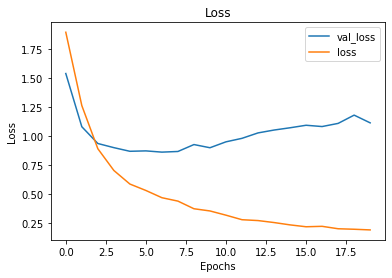

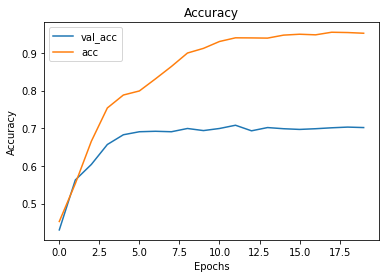

In [46]:
visualize_training_results(stem_results_4)

#### Saving Model

In [47]:
stem_model_4.save('models/stem_model_4')

## Batch 4 And Stem Model 5

### Batch 4

In [48]:
label_batch(batch_4, stem_model_4)

C:\Users\Steven\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [49]:
df_label_stem.drop(columns = ['index'], inplace=True)
df_label_stem = df_label_stem.append(batch_4).reset_index()

### Stem Model 5

In [50]:
X = data_to_sequences(df_label_stem)
y = pd.get_dummies(df_label_stem['sentiment']).values

X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(X, y, test_size = 0.2, random_state=0)

In [51]:
stem_model_5 = Sequential()

embed_in = len(total_vocab_stem)
embed_out = max(length_list)
lambda_coeff = 0.1

stem_model_5.add(Embedding(embed_in, embed_out))
stem_model_5.add(LSTM(8, return_sequences=True))
stem_model_5.add(GlobalMaxPool1D())
stem_model_5.add(Dropout(0.4))
stem_model_5.add(Dense(25, activation='tanh', kernel_regularizer=regularizers.l2(lambda_coeff)))
stem_model_5.add(Dense(3, activation='softmax'))

stem_model_5.compile(loss='categorical_crossentropy',
                   optimizer='Adam',
                   metrics=['accuracy'])

stem_results_5 = stem_model_5.fit(X_train_stem, y_train_stem, epochs=20, batch_size=30, validation_split=0.3)

Train on 5688 samples, validate on 2438 samples
Epoch 1/20
5688/5688 [==============================] - 11s 2ms/step - loss: 1.7068 - acc: 0.4506 - val_loss: 1.3004 - val_acc: 0.4446
Epoch 2/20
5688/5688 [==============================] - 11s 2ms/step - loss: 1.0357 - acc: 0.5819 - val_loss: 0.9066 - val_acc: 0.6177
Epoch 3/20
5688/5688 [==============================] - 10s 2ms/step - loss: 0.7274 - acc: 0.7326 - val_loss: 0.8106 - val_acc: 0.6936
Epoch 4/20
5688/5688 [==============================] - 10s 2ms/step - loss: 0.5408 - acc: 0.8402 - val_loss: 0.8290 - val_acc: 0.7084
Epoch 5/20
5688/5688 [==============================] - 9s 2ms/step - loss: 0.4402 - acc: 0.8692 - val_loss: 0.7887 - val_acc: 0.7219
Epoch 6/20
5688/5688 [==============================] - 10s 2ms/step - loss: 0.3663 - acc: 0.9056 - val_loss: 0.8084 - val_acc: 0.7334
Epoch 7/20
5688/5688 [==============================] - 10s 2ms/step - loss: 0.3172 - acc: 0.9202 - val_loss: 0.8157 - val_acc: 0.7375
Epoch 8/

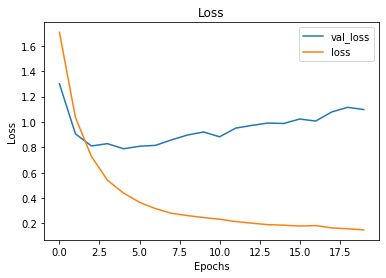

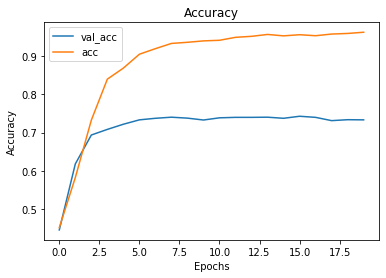

In [52]:
visualize_training_results(stem_results_5)

#### Saving Model

In [53]:
stem_model_5.save('models/stem_model_5')

# Conclusion

Yay! All the data is labeled and a final model is made. **This model will be used to predict sentiment on live-streamed tweets about Amazon.** This can be found in the notebook **`twitter_streaming.ipynb`.** The following code just saves the `Tokenizer` and final `DataFrame` in case I need them again. Feel free to ignore it.

## Saving Tokenizer For Easy Loading In `twitter_streaming.ipynb`

In [54]:
import pickle

with open('models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Saving Final Labeled DataFrame

In [57]:
df_label_stem.drop('index', inplace=True, axis=1)

In [60]:
df_label_stem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10158 entries, 0 to 10157
Data columns (total 2 columns):
sentiment    10158 non-null int64
tweet        10158 non-null object
dtypes: int64(1), object(1)
memory usage: 158.8+ KB


In [61]:
df_label_stem.to_csv('models/labeled_dataframe.csv')

### Saving Alt Version That Won't Load The Lists As Strings

In [62]:
df_copy = df_label_stem.copy()

In [65]:
df_copy.tweet[0]

['webcomicart',
 'thing',
 'ive',
 'practic',
 'lot',
 'mayb',
 'pair',
 'giant',
 'breast',
 'help',
 'drown',
 'neg',
 'internet']

In [68]:
for i in range(len(df_copy)):
    df_copy.tweet[i] = " ".join(df_copy.tweet[i])

C:\Users\Steven\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [69]:
df_copy

,sentiment,tweet
0,3,webcomicart thing ive practic lot mayb pair giant breast help drown neg internet
1,1,latenight phone call miss kid murder famili one talk promis made kept though might mean 15 yr old death kdp select amazon print
2,3,would mix medicin stuff help smell strong hard notic there anyth els mix
3,3,best beliv imma take advantag amazon prime account
4,2,well check gluttoni alreadi avail purchas ’ look stori demand boss suddenli discov desper realli need tast assist ’ cream today lucki day
...,...,...
10153,3,econom driver amazon fire
10154,2,5 excel read couldnt put
10155,3,darkest lie ever told cost million live protect marco arrigoni will sacrific one life expos it—hi packag one man ’ battl truth amazon
10156,1,cautionari tale could possibl happen environment protect dissolv amp water amp air becom pollutedit frighten say least night sciuru


In [70]:
df_copy.to_csv('models/df_copy.csv')

In [71]:
type(df_copy.tweet[0])

str